# Level 1 — Clustering Pipeline 



## 0. Imports & Global Settings
Set random seeds and plotting style for reproducibility.


In [24]:
import numpy as np
import pandas as pd
from pathlib import Path  # For robust path handling
import matplotlib.pyplot as plt
from scipy import stats  # Statistical tests
import seaborn as sns


from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import (
    log2_transform,
    zscore_normalize,
)

from src.bladder_proteomics.dimensionality_reduction import apply_pca, apply_umap
from src.bladder_proteomics.k_selection import evaluate_k_selection_one
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.plotting import (
    set_plot_style,
    plot_pca,
    plot_umap,
    plot_cluster_sizes,
)

np.random.seed(42)
set_plot_style(dpi=120)


## 0.1 Config
Centralized paths and hyperparameters for reproducibility.


In [25]:
# Centralize paths and key hyperparameters for reproducibility
DATA_DIR = Path(".")  # Data files are in repo root
PROTEOMICS_PATH = DATA_DIR / "proteomics.txt"
METADATA_PATH = DATA_DIR / "metadata.csv"

# Hyperparameters used throughout the notebook
M_GRID = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
N_MAX = 20
SEED = 42


## 1. Load & Align Proteomics and Metadata
Load proteomics and clinical metadata, and align them by Patient ID.


In [26]:
# Use explicit paths to avoid working-directory surprises
if not PROTEOMICS_PATH.exists():
    raise FileNotFoundError(f"Proteomics file not found: {PROTEOMICS_PATH}")
if not METADATA_PATH.exists():
    raise FileNotFoundError(f"Metadata file not found: {METADATA_PATH}")

proteomics, metadata = load_data(
    PROTEOMICS_PATH,
    METADATA_PATH,
    transpose=True
)

validate_data(proteomics)
validate_data(metadata)

# Align by Patient ID
common_ids = proteomics.index.intersection(metadata.index)
proteomics = proteomics.loc[common_ids]
metadata = metadata.loc[common_ids]

print(f"Number of patients after alignment: {len(common_ids)}")


Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Data shape (samples × features): (140, 13)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Number of patients after alignment: 140


## 1.1 Data Quality Summary
Quick checks for missingness, zero inflation, and basic shape.


In [27]:
# Basic data quality checks for transparency
print(f"Proteomics shape: {proteomics.shape}")
print(f"Metadata shape: {metadata.shape}")

missing_proteomics = int(proteomics.isna().sum().sum())
missing_metadata = int(metadata.isna().sum().sum())
print(f"Missing values (proteomics): {missing_proteomics}")
print(f"Missing values (metadata): {missing_metadata}")

zero_count = int((proteomics == 0).sum().sum())
zero_ratio = zero_count / float(proteomics.size)
print(f"Zero entries (proteomics): {zero_count} ({zero_ratio:.2%})")


Proteomics shape: (140, 3112)
Metadata shape: (140, 13)
Missing values (proteomics): 0
Missing values (metadata): 0
Zero entries (proteomics): 0 (0.00%)


## 2. Pipeline-specific helper functions

This part contains the functions to be tuned explicitly for optimizing pipeline. 

`select_representative_npc`
- For a fixed PCA embedding, iterate over different numbers of principal components.

- For each `n_pc`, run k-means clustering and compute both elbow-based and silhouette-based optimal k.

- If both elbow and silhouette agree on a same optimal k, select the `n_pc` with the highest silhouette score; otherwise mark the result as "unstable".

`select_top_m_by_cv`

- Apply log2 transformation to the proteomics matrix before compute CV.

- Compute CV for each protein across patients.

- Select the top m proteins with the highest CV for downstream PCA and clustering.

In [28]:
def select_representative_npc(
    pca_df: pd.DataFrame,
    pc_grid,
    k_max=20,
    n_samples=None,
):
    records = []

    if n_samples is None:
        n_samples = pca_df.shape[0]

    for npc in pc_grid:
        X = pca_df.iloc[:, :npc]
        # Keep k within valid bounds for silhouette (k < n_samples)
        k_max_safe = min(k_max, n_samples - 1)
        if k_max_safe < 2:
            continue  # Not enough samples to evaluate silhouette

        res = evaluate_k_selection_one(X, k_max=k_max_safe)

        records.append({
            "n_pc": npc,
            "elbow_k": res["elbow_k"],
            "best_k": res["best_k_sil"],
            "best_sil": res["best_sil"],
        })

    df = pd.DataFrame(records)

    consistent = df[df["elbow_k"] == df["best_k"]]

    if consistent.empty:
        return None, df

    best_row = consistent.loc[consistent["best_sil"].idxmax()]
    return best_row, df


def select_top_m_by_cv(X: pd.DataFrame, m: int) -> pd.DataFrame:
    X_log, _ = log2_transform(X)
    mean = X_log.mean(axis=0)
    std = X_log.std(axis=0)
    # Use absolute mean to avoid negative CV after log2
    cv = std / mean.abs().replace(0, np.nan)
    cv = cv.fillna(0.0)  # Keep NaNs from dominating the ranking
    top_features = cv.sort_values(ascending=False).head(m).index
    return X_log[top_features]


## 3. Feature-selection Robustness

Evaluate clustering stability across different numbers of selected proteins (m).

- For each candidate number of selected proteins (m), the pipeline performs CV-based feature selection followed by z-score normalization.

- PCA is then fitted once up to a fixed maximum number of components (at most 20), and clustering stability is evaluated by scanning different n_pc values within this fixed PCA space.

- For each m, a representative (n_pc, k) pair is selected where elbow and silhouette criteria agree on the best K, and the explained variance of the selected PCs is recorded.



In [29]:
m_grid = M_GRID  # Hyperparameter grid for feature selection
n_max = N_MAX  # Hyperparameter for PCA max components
k_results = []

n_samples = proteomics.shape[0]

for m in m_grid:
    # Feature selection
    X_m = select_top_m_by_cv(proteomics, m)
    X_m_scaled = zscore_normalize(X_m, axis=0)

    # FIXED PCA FIT (exactly like old code)
    pca_nmax = min(n_max, X_m_scaled.shape[1])
    if pca_nmax < 2:
        k_results.append({
            "m": m,
            "status": "unstable",
        })
        continue

    pca_full, pca_model = apply_pca(
        X_m_scaled,
        n_components=pca_nmax,
        return_model=True
    )

    # Scan n_pc in the fixed PCA space
    pc_grid = list(range(2, pca_nmax + 1))
    k_max = pca_nmax

    best_row, df_npc = select_representative_npc(
        pca_full,
        pc_grid=pc_grid,
        k_max=k_max,
        n_samples=n_samples,
    )

    if best_row is None:
        k_results.append({
            "m": m,
            "status": "unstable",
        })
        continue

    explained = pca_model.explained_variance_ratio_
    var_explained_npc = explained[:int(best_row["n_pc"])].sum()

    k_results.append({
        "m": m,
        "n_pc": best_row["n_pc"],
        "k": best_row["best_k"],
        "best_sil": best_row["best_sil"],
        "var_explained": var_explained_npc,
        "status": "stable",
    })

k_summary = pd.DataFrame(k_results)
k_summary


,m,status,n_pc,k,best_sil,var_explained
0,5,unstable,NaN,NaN,NaN,NaN
1,10,unstable,NaN,NaN,NaN,NaN
2,15,unstable,NaN,NaN,NaN,NaN
3,20,stable,6.0,7.0,0.902679,0.989161
4,25,stable,6.0,7.0,0.858757,0.960421
5,30,unstable,NaN,NaN,NaN,NaN
6,35,unstable,NaN,NaN,NaN,NaN
7,40,unstable,NaN,NaN,NaN,NaN
8,45,unstable,NaN,NaN,NaN,NaN
9,50,unstable,NaN,NaN,NaN,NaN


### 3.2 Final choice of m and k

- Only stable solutions explaining at least 80% variance are kept, and the final configuration is chosen as the one with the highest silhouette score.

### 3.2.1 Selection Rules (Why this is chosen)
We keep configurations where elbow and silhouette agree on K, and where the selected PCs explain at least 80% variance.
Among these stable candidates, we pick the highest silhouette score.


In [31]:
# keep only stable rows
stable_df = k_summary[
    (k_summary["status"] == "stable") &
    (k_summary["var_explained"] >= 0.8)
].copy()

# select the row with maximum silhouette
best_final = stable_df.loc[stable_df["best_sil"].idxmax()]

best_final


m                      20
status             stable
n_pc                  6.0
k                     7.0
best_sil         0.902679
var_explained    0.989161
Name: 3, dtype: object

### 3.2.2 Save Selection Results
Persist selection tables for reproducibility.


In [32]:
# Save selection outputs for reproducibility
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

k_summary.to_csv(results_dir / "k_summary.csv", index=False)
best_final.to_frame().T.to_csv(results_dir / "best_final.csv", index=False)


## 4. Visulization



### 4.1 Reconstruction of data

In [33]:
m_star = int(best_final["m"])
n_pc_star = int(best_final["n_pc"])
k_star = int(best_final["k"])

# feature selection
X_m = select_top_m_by_cv(proteomics, m_star)
X_m_scaled = zscore_normalize(X_m, axis=0)

# PCA fit to fixed 20 (same rule as before)
pca_nmax = min(n_max, X_m_scaled.shape[1])
pca_full, pca_model = apply_pca(
    X_m_scaled,
    n_components=pca_nmax,
    return_model=True
)

# clustering space
X_cluster = pca_full.iloc[:, :n_pc_star]

labels = kmeans_cluster(
    X_cluster,
    n_clusters=k_star,
    random_state=SEED,
    align_labels=True
)


### 4.2 PCA plot

(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'PCA (m=20, n_pc=6, k=7)'}, xlabel='PC1', ylabel='PC2'>)

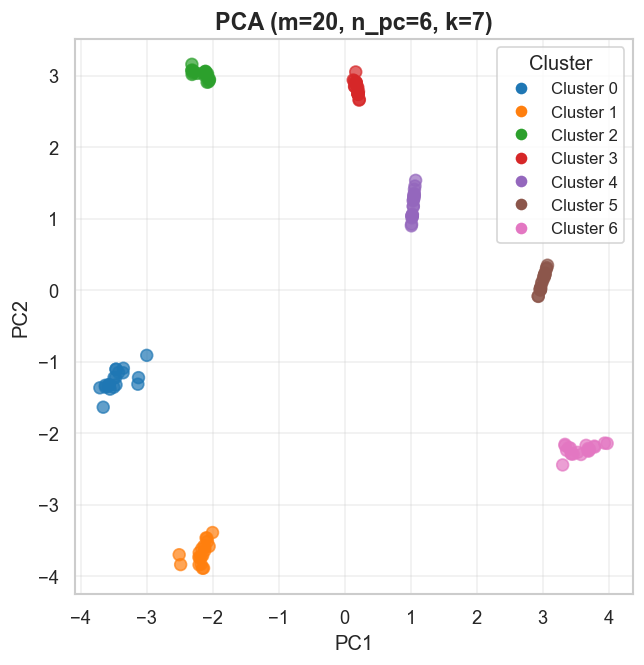

In [34]:
plot_pca(
    pca_full.iloc[:, :2],
    labels=labels,
    title=f"PCA (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6)
)


### 3.3 UMAP plot

/Users/jiayima/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'UMAP (m=20, n_pc=6, k=7)'}, xlabel='UMAP1', ylabel='UMAP2'>)

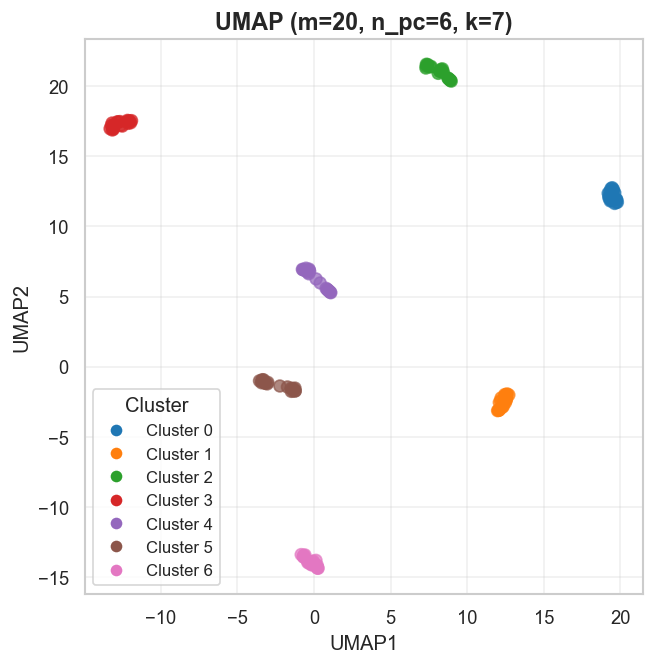

In [35]:
umap_2d = apply_umap(
    X_cluster,
    n_components=2,
    random_state=SEED
)


plot_umap(
    umap_2d,
    labels=labels,
    title=f"UMAP (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6),
)


### 4.4 Cluster Size Distribution

<Axes: title={'center': 'Cluster size distribution'}, xlabel='Number of patients'>

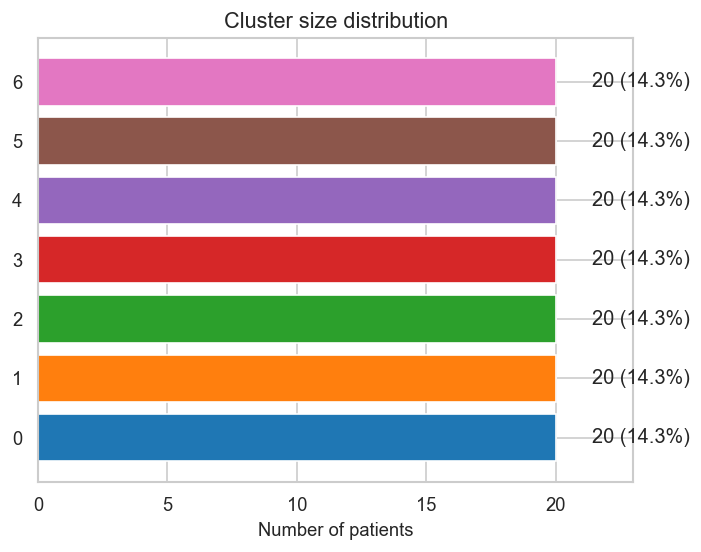

In [36]:
plot_cluster_sizes(
    pd.Series(labels, index=X_cluster.index),
    title="Cluster size distribution",
)


## 5. Metadata Evaluation
This is not a new clustering, just for evaluation or possible interpretation.

### 5.1 Alignment

In [37]:
metadata_aligned = metadata.loc[X_cluster.index].copy()
metadata_aligned["Cluster"] = labels

### 5.2 Numerical Metadata (Age, Tumor_Size etc.)

### 5.2.1 Statistical Test (Numeric)
Kruskal–Wallis test across clusters for numeric metadata.


In [38]:
# Kruskal–Wallis test for numeric metadata
for col in num_cols:
    groups = [
        metadata_aligned.loc[metadata_aligned["Cluster"] == k, col].dropna()
        for k in sorted(metadata_aligned["Cluster"].unique())
    ]
    if all(len(g) > 0 for g in groups):
        stat, pval = stats.kruskal(*groups)
        print(f"{col}: Kruskal–Wallis H={stat:.3f}, p={pval:.3g}")
    else:
        print(f"{col}: insufficient data for test")


Tumor_Size_mm: Kruskal–Wallis H=121.000, p=1e-23


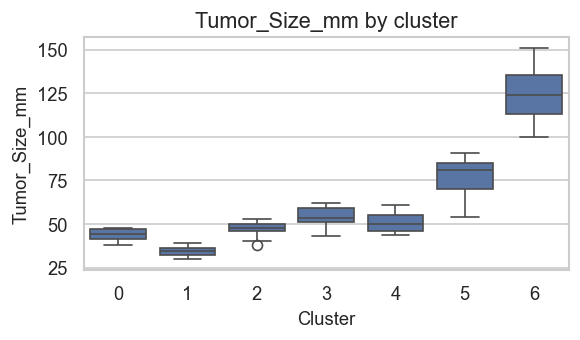

In [39]:

num_cols = ["Tumor_Size_mm"]
#  "Age", "Follow_up_Duration_months" seems non-relevant

for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(
        data=metadata_aligned,
        x="Cluster",
        y=col
    )
    plt.title(f"{col} by cluster")
    plt.tight_layout()
    plt.show()


- There is a clear correlation between cluster and tumor size. 

Why clusters are sorted by tumor size for the tasks below? 

- Clusters are ordered by increasing median tumor size to impose a clinically interpretable progression axis, allowing systematic comparison of survival and treatment response patterns across clusters.

In [40]:
cluster_order = (
    metadata_aligned
    .groupby("Cluster")["Tumor_Size_mm"]
    .median()
    .sort_values()
    .index
    .tolist()
)

cluster_order


[1, 0, 2, 4, 3, 5, 6]

### 5.2.1 Cluster Order Mapping
Keep track of how cluster labels are re-ordered for interpretation.


In [41]:
# Map original cluster labels to tumor-size order
cluster_order_map = {label: rank for rank, label in enumerate(cluster_order)}
cluster_order_map


{1: 0, 0: 1, 2: 2, 4: 3, 3: 4, 5: 5, 6: 6}

### 5.3 Categorical Metadata Histological_Grade, Metastasis, Survival etc.）

### 5.3.1 Statistical Test (Categorical)
Chi-square test of independence for categorical metadata.


In [42]:
# Chi-square test for categorical metadata
for col in cat_cols:
    ct = pd.crosstab(metadata_aligned["Cluster"], metadata_aligned[col])
    if ct.shape[0] > 1 and ct.shape[1] > 1:
        chi2, pval, dof, _ = stats.chi2_contingency(ct)
        print(f"{col}: chi2={chi2:.3f}, dof={dof}, p={pval:.3g}")
    else:
        print(f"{col}: insufficient categories for test")


Survival_Status: chi2=77.549, dof=6, p=1.15e-14
Response_to_Treatment: chi2=181.148, dof=18, p=5.68e-29


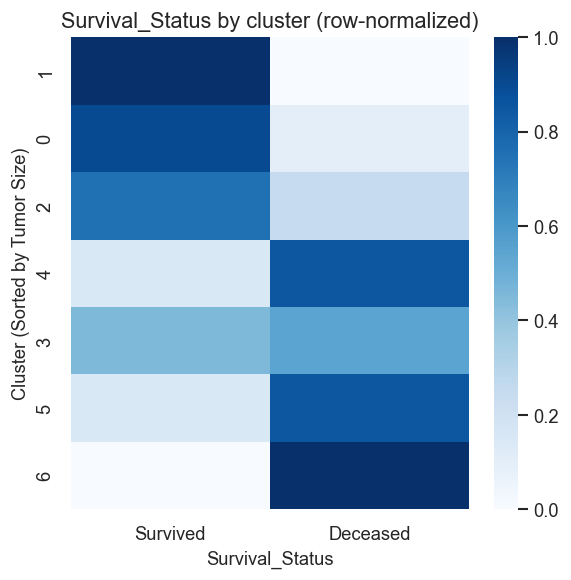

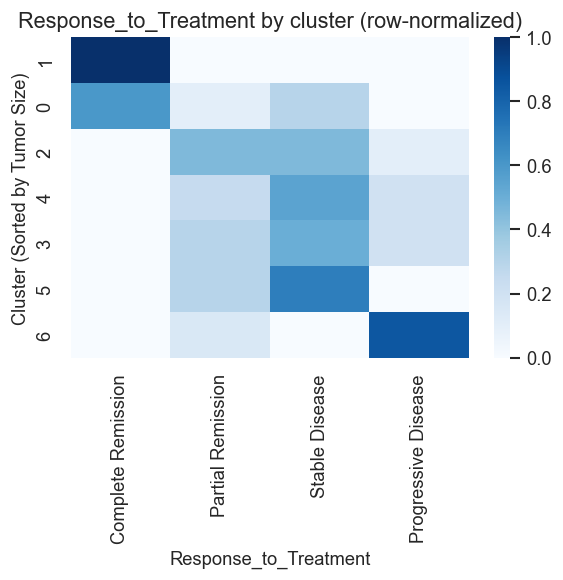

In [43]:
cat_cols = [
    "Survival_Status",
    "Response_to_Treatment",
]
# "Histological_Grade", seems not very relevant
# "Metastasis", seems not very relevant
# "Treatment", seems not very relevant
# "Lymph_Node_Involvement", seems not very relevant

for col in cat_cols:
    ct = pd.crosstab(metadata_aligned["Cluster"], metadata_aligned[col])
    ct = ct.loc[cluster_order]
    # Normalize per cluster to compare proportions fairly
    ct = ct.div(ct.sum(axis=1), axis=0)

    if col == "Survival_Status":
        ct = ct[["Survived", "Deceased"]]
    if col == "Response_to_Treatment":
        ct = ct[["Complete Remission", "Partial Remission", "Stable Disease", "Progressive Disease"]]

    plt.figure(figsize=(5, 5))
    sns.heatmap(
        ct,
        cmap="Blues",
        fmt=".2f"
    )
    plt.title(f"{col} by cluster (row-normalized)")
    plt.ylabel("Cluster (Sorted by Tumor Size)")
    plt.xlabel(f"{col}")
    plt.tight_layout()
    plt.show()


### Qualitative interpretation of the Metadata vs cluster

The survival heatmap shows a clear shift from predominantly survived patients in small-tumor clusters to predominantly deceased patients in large-tumor clusters, indicating strong clinical stratification by cluster.

The treatment-response heatmap reveals a parallel trend, with early clusters enriched for complete or partial remission and later clusters dominated by stable or progressive disease, supporting the clinical relevance of the identified subpopulations.
